<a href="https://colab.research.google.com/github/abaskon/Particle_Filter_Localisation/blob/main/AMCL_DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (15,8)
mpl.rcParams['axes.grid'] =True
  

In [10]:
!git clone https://github.com/abaskon/Particle_Filter_Localisation.git

fatal: destination path 'Particle_Filter_Localisation' already exists and is not an empty directory.


In [11]:
amcl = pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/amcl_pose.csv')
odom_f =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/odometry-filtered.csv') 
odom =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/odom.csv')
tf =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/tf.csv')
clock =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/clock.csv')

In [12]:
amcl.head()

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,pose.pose.position.x,pose.pose.position.y,pose.pose.position.z,pose.pose.orientation.x,pose.pose.orientation.y,pose.pose.orientation.z,pose.pose.orientation.w,pose.covariance
0,34.674,0,10,397000000,map,0.012766,-0.001858,0.0,0.0,0.0,0.000086,1.000000,"(0.2470653041573616, 0.0019165315976033225, 0...."
1,56.439,1,56,398000000,map,0.248594,0.094097,0.0,0.0,0.0,0.178186,0.983997,"(0.18950598300327587, -0.005191661325132511, 0..."
2,61.427,2,61,398000000,map,0.610166,0.239486,0.0,0.0,0.0,0.177205,0.984174,"(0.15812233142807763, -0.0028520728322717626, ..."
3,65.827,3,65,798000000,map,1.010377,0.289293,0.0,0.0,0.0,0.020810,0.999783,"(0.12805022456698278, 0.0017301901724648405, 0..."
4,70.021,4,69,998000000,map,1.420104,0.292532,0.0,0.0,0.0,0.022802,0.999740,"(0.10035431183717636, 0.0005044863828376212, 0..."


In [13]:
pip install squaternion 

In [14]:
from squaternion import Quaternion

In [15]:

def find_theta(data,value):
  data['theta']=0
  for i in range (0,len(data)):
    quaternion = Quaternion(data["pose.pose.orientation.x"][i],data["pose.pose.orientation.y"][i],data["pose.pose.orientation.z"][i],data["pose.pose.orientation.w"][i])
    data['theta'][i] = data['theta'][i]+ quaternion.to_euler(degrees=True)[value]
  

In [16]:
amcl_position = amcl.pivot("pose.pose.position.x","pose.pose.position.y")

In [17]:
import pandas as pd
from pandas_datareader import data
import seaborn as sns
import io
sns.set(style="darkgrid")

In [18]:
tf.head()

,Time,transforms
0,34.674,[header: \n seq: 0\n stamp: \n secs: 34\n...
1,34.695,[header: \n seq: 0\n stamp: \n secs: 34\n...
2,34.696,[header: \n seq: 0\n stamp: \n secs: 34\n...
3,34.700,[header: \n seq: 0\n stamp: \n secs: 34\n...
4,34.707,[header: \n seq: 0\n stamp: \n secs: 34\n...


In [ ]:
#print(tf.transforms[0])
# Strips the newline character

tf['pose.pose.position.x'] = 0.0
tf['pose.pose.position.y'] = 0.0
tf['pose.pose.orientation.x'] =0.0
tf['pose.pose.orientation.y'] =0.0
tf['pose.pose.orientation.z'] =0.0
tf['pose.pose.orientation.w'] =0.0

for i in range (0,len(tf)):
  buf = io.StringIO(tf.transforms[i])
  Lines = buf.readlines()
  tf['pose.pose.position.x'][i] = float(Lines[9].strip()[3:15])
  tf['pose.pose.position.y'][i] = float(Lines[10].strip()[3:15])
  tf['pose.pose.orientation.x'][i] = float(Lines[13].strip()[3:15])
  tf['pose.pose.orientation.y'][i]= float(Lines[14].strip()[3:15])
  tf['pose.pose.orientation.z'][i] = float(Lines[15].strip()[3:15])
  tf['pose.pose.orientation.w'][i] = float(Lines[15].strip()[3:15])

In [20]:
find_theta(amcl,0)
find_theta(odom_f,0)
find_theta(tf,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
tf['time']=pd.to_datetime(tf['Time'],unit='s')
tf = tf.set_index('time').resample("2s").mean().reset_index()

In [22]:
tf.head()

,time,Time,pose.pose.position.x,pose.pose.position.y,pose.pose.orientation.x,pose.pose.orientation.y,pose.pose.orientation.z,pose.pose.orientation.w,theta
0,1970-01-01 00:00:34,35.339059,-1.295132,0.609822,-2.187864,0.000938,0.336946,0.336946,5.346405
1,1970-01-01 00:00:36,37.004070,-1.632769,0.175619,-2.190694,0.000933,0.320162,0.320162,5.043478
2,1970-01-01 00:00:38,39.004087,-1.394786,0.662305,-2.199799,0.000929,0.320200,0.320200,5.043478
3,1970-01-01 00:00:40,41.004017,-1.450942,0.089250,-2.208905,0.000925,0.320119,0.320119,5.043478
4,1970-01-01 00:00:42,43.004070,-1.908164,0.533344,-2.089917,0.000809,0.320130,0.320130,5.100000


No handles with labels found to put in legend.


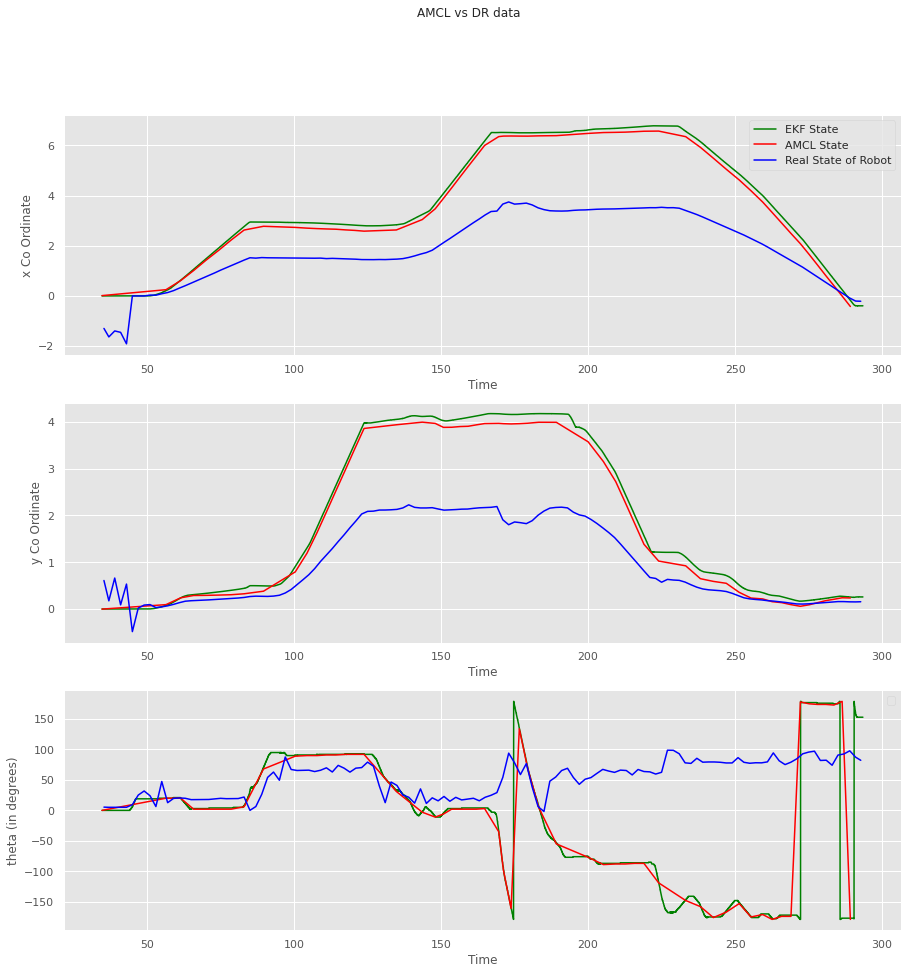

In [27]:
plt.style.use('ggplot')

fig, ax = plt.subplots(3)
fig.suptitle('AMCL vs DR data')
# Plot 0
ax[0].plot(odom_f.Time, odom_f["pose.pose.position.x"], color="green")
ax[0].plot(amcl.Time, amcl["pose.pose.position.x"], color="red")
ax[0].plot(tf.Time, tf["pose.pose.position.x"], color="blue")

ax[0].set(xlabel='Time', ylabel='x Co Ordinate')
ax[0].legend(["EKF State", "AMCL State","Real State of Robot"], loc ="upper right")

# Plot 1
ax[1].plot(odom_f.Time, odom_f["pose.pose.position.y"], color="green")
ax[1].plot(amcl.Time, amcl["pose.pose.position.y"], color="red")
ax[1].set(xlabel='Time', ylabel='y Co Ordinate')
ax[1].plot(tf.Time, tf["pose.pose.position.y"], color="blue")

# Plot 2
ax[2].plot(odom_f.Time, odom_f["theta"], color="green")
ax[2].plot(amcl.Time, amcl["theta"], color="red")
ax[2].set(xlabel='Time', ylabel='theta (in degrees)')
ax[2].plot(tf.Time, tf["theta"], color="blue")

# show legend
plt.legend()
plt.rcParams['figure.figsize'] = [15, 15]
# show graph
plt.show()